# Policy Uncertainty as a Predictor of CME Price Movement

This study investigates whether shifts in implied probability from prediction markets can
predict next-day returns in CME Group futures.

The core hypothesis is grounded in CME's business model: as a transaction-fee-driven exchange, CME's revenue is a direct function of hedging volume, and hedging volume is a direct function of policy uncertainty. If prediction market entropy captures genuine uncertainty shocks, it should lead observable price appreciation in CME.

The prediction market in question is Polymarket's contracts on the outcome of the March 2026 Federal Reserve rate decision.

## Imports and Constants

### Imports

In [32]:
from collections import defaultdict
import csv
from datetime import datetime, timezone
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
from pathlib import Path
import requests
import scipy.stats as stats
import statsmodels.api as sm

### Constants

In [33]:
PM_DIR = Path("data/polymarket")
CME_OHLC_PATH = Path("data/cme/daily_ohlc.csv")
VOO_OHLC_PATH = Path("data/voo/daily_ohlc.csv")
MOVE_OHLC_PATH = Path("data/move/daily_ohlc.csv")
PROXY_PM = "will-the-fed-increase-interest-rates-by-25-bps-after-the-march-2026-meeting_NO.csv"

### Download Polymarket historic data
Download historic price data from Polymarket. [See Documentation](https://docs.polymarket.com/developers/CLOB/timeseries)

| From               | To                  |
| ------------------ | ------------------- |
| November 1st, 2025 | February 16th, 2026 |

In [34]:
FIELD_NAMES = ["p", "t"]

START_DATES = [
    int(datetime(2025, 11, 1, tzinfo=timezone.utc).timestamp()),
    int(datetime(2025, 11, 16, tzinfo=timezone.utc).timestamp()),
    int(datetime(2025, 12, 1, tzinfo=timezone.utc).timestamp()),
    int(datetime(2025, 12, 16, tzinfo=timezone.utc).timestamp()),
    int(datetime(2026, 1,  1, tzinfo=timezone.utc).timestamp()),
    int(datetime(2026, 1, 16, tzinfo=timezone.utc).timestamp()),
    int(datetime(2026, 2,  1, tzinfo=timezone.utc).timestamp()),
]

END_DATES = [
    int(datetime(2025, 11, 15, tzinfo=timezone.utc).timestamp()),
    int(datetime(2025, 11, 30, tzinfo=timezone.utc).timestamp()),
    int(datetime(2025, 12, 15, tzinfo=timezone.utc).timestamp()),
    int(datetime(2025, 12, 31, tzinfo=timezone.utc).timestamp()),
    int(datetime(2026, 1, 15, tzinfo=timezone.utc).timestamp()),
    int(datetime(2026, 1, 31, tzinfo=timezone.utc).timestamp()),
    int(datetime(2026, 2, 16, tzinfo=timezone.utc).timestamp()),
]

result = defaultdict(list)

with open('data/fed-decision-in-march-885_SUMMARY.json') as f:
    polymarket_summary = json.load(f)
    markets = polymarket_summary["markets"]
    
    for market in markets:
        market_id = market["id"]
        market_name = market["question"]
        slug = market["slug"]
        outcomes = json.loads(market["outcomes"])
        clobs = [int(clob_str) for clob_str in json.loads(market["clobTokenIds"])]
        
        
        for outcome, clob in zip(outcomes, clobs):
            security = f"{slug}_{outcome.upper()}"

            maybe_out = os.path.join(PM_DIR, f"{security}.csv")
            if os.path.exists(maybe_out):
                print(f"skipping {maybe_out}")
                continue
            
            for start, end in zip(START_DATES, END_DATES):
                request_curl = f'https://clob.polymarket.com/prices-history?market={clob}&startTs={start}&endTs={end}'

                res = requests.get(request_curl)
                if res.status_code != 200:
                    print(request_curl)
                    reason = res.json()
                    raise Exception(f"{res.status_code}: could not fetch for {market_name}: {reason}")
            
                result[security] += (res.json()["history"])
            
for security, data in result.items():
    # de-dup by timestamp; keep last occurrence
    by_t = {}
    for row in data:
        t = int(row["t"])
        by_t[t] = {"p": float(row["p"]), "t": t}

    rows = [by_t[t] for t in sorted(by_t.keys())]

    out = os.path.join(PM_DIR, f"{security}.csv")
    with open(out, mode="w", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=FIELD_NAMES)
        writer.writeheader()
        writer.writerows(rows)

        print(out)

skipping data/polymarket/will-the-fed-decrease-interest-rates-by-50-bps-after-the-march-2026-meeting_YES.csv
skipping data/polymarket/will-the-fed-decrease-interest-rates-by-50-bps-after-the-march-2026-meeting_NO.csv
skipping data/polymarket/will-the-fed-decrease-interest-rates-by-25-bps-after-the-march-2026-meeting_YES.csv
skipping data/polymarket/will-the-fed-decrease-interest-rates-by-25-bps-after-the-march-2026-meeting_NO.csv
skipping data/polymarket/will-there-be-no-change-in-fed-interest-rates-after-the-march-2026-meeting_YES.csv
skipping data/polymarket/will-there-be-no-change-in-fed-interest-rates-after-the-march-2026-meeting_NO.csv
skipping data/polymarket/will-the-fed-increase-interest-rates-by-25-bps-after-the-march-2026-meeting_YES.csv
skipping data/polymarket/will-the-fed-increase-interest-rates-by-25-bps-after-the-march-2026-meeting_NO.csv


## Set up OHLC dataframes

In [35]:
def load_ohlc(path):
    ohlc_df = pd.read_csv(path, sep="\t")
    
    s = ohlc_df["Exchange Date"].astype(str).str.strip()
    s = s.str.replace(r"-(\d{2})$", r"-20\1", regex=True)
    ohlc_df["Exchange Date"] = pd.to_datetime(s, format="%d-%b-%Y", errors="raise")

    ohlc_df = ohlc_df.set_index("Exchange Date").sort_index()

    ohlc_df = ohlc_df[["Close"]].copy()
    ohlc_df["Close"] = pd.to_numeric(ohlc_df["Close"], errors="coerce")

    # Correct log returns
    ohlc_df["ret"] = np.log(ohlc_df["Close"]).diff()

    return ohlc_df


cme_ohlc_df = load_ohlc(CME_OHLC_PATH)
voo_ohlc_df = load_ohlc(VOO_OHLC_PATH).rename(columns={"ret": "voo_ret", "Close": "voo_Close"})
move_ohlc_df = load_ohlc(MOVE_OHLC_PATH).rename(columns={"ret": "move_ret", "Close": "move_Close"})


## Standardize data format

In [36]:
pm_df = pd.read_csv(PM_DIR / PROXY_PM)

pm_df["t"] = pd.to_datetime(pm_df["t"], unit='s')
pm_df = pm_df.set_index("t").sort_index()

pm_df = pm_df.rename(columns={"p": "pm_prob"})[["pm_prob"]].copy()
pm_df = pm_df[["pm_prob"]].copy()
pm_df["pm_prob"] = pd.to_numeric(pm_df["pm_prob"], errors="coerce")
pm_df.head()

,pm_prob
t,
2025-11-01 00:00:06,0.96
2025-11-01 00:01:05,0.96
2025-11-01 00:02:04,0.96
2025-11-01 00:03:04,0.96
2025-11-01 00:04:04,0.96


## Calculate every business day's uncertainty on Polymarket

Binary entropy is appropriate because a Polymarket contract represents a two-outcome event, so the uncertainty of the market at probability $p$ is fully described by the Bernoulli distribution, whose uncertainty is given by the binary entropy function:
$$
H(p)=−(p\ln{p}+(1−p)\ln{(1−p)})
$$

See: https://en.wikipedia.org/wiki/Binary_entropy_function

In [37]:
pm_df2 = pm_df.copy()

# make the index timezone-aware then convert to NY time
pm_df2.index = pd.to_datetime(pm_df2.index, unit="s", utc=True).tz_convert("America/New_York") \
    if pm_df2.index.tz is None else pm_df2.index.tz_convert("America/New_York")

# keep only prints up to 16:00 NY time (CME close)
pm_preclose = pm_df2.between_time("00:00", "16:00")

# group by *the filtered index's* calendar date
pm_close = pm_preclose.groupby(pm_preclose.index.normalize()).last()
# make index match CME index type (naive dates)
pm_close.index = pm_close.index.tz_localize(None)
pm_close = pm_close.rename(columns={"pm_prob": "pm_prob"})

df = cme_ohlc_df.merge(pm_close, left_index=True, right_index=True, how="left").dropna()

In [38]:
p = df["pm_prob"].clip(1e-6, 1-1e-6)
df["uncert"] = -(p*np.log(p) + (1-p)*np.log(1-p))
df["d_uncert"] = df["uncert"].diff()

df.tail()

,Close,ret,pm_prob,uncert,d_uncert
Exchange Date,,,,,
2026-02-09,307.24,0.016309,0.9905,0.053691,0.000000
2026-02-10,306.76,-0.001564,0.9905,0.053691,0.000000
2026-02-11,302.48,-0.014051,0.9935,0.039213,-0.014479
2026-02-12,301.64,-0.002781,0.9925,0.044168,0.004956
2026-02-13,303.07,0.004730,0.9935,0.039213,-0.004956


## Method

Identifies large uncertainty shocks (85th quantile by absolute change in entropy), then tests whether they predict next-period returns using OLS.
- without controls
- with market controls (VOO (proxy for general market movement) and MOVE (proxy for interest rate uncertainty))

### Constants
This study employs a limit for statistical significance of $p < 0.05$ and a quantile of $0.85$

In [39]:
QUANTILE = 0.85
P = 0.05

In [40]:
threshold = df["d_uncert"].abs().quantile(QUANTILE)
df["big_uncert"] = (df["d_uncert"].abs() > threshold).astype(int)

df = df.join(voo_ohlc_df[["voo_ret"]], how="left")
df = df.join(move_ohlc_df[["move_ret"]], how="left")

MAX_LAGS = int(len(df) ** (1/4)) #T^.25, where T is the number of time periods

y_1 = df["ret"].shift(-1)
X_1 = sm.add_constant(df[["big_uncert"]])
model_no_control = sm.OLS(y_1, X_1, missing="drop").fit(cov_type="HAC", cov_kwds={"maxlags":MAX_LAGS})

y_2 = df["ret"].shift(-1)
X_2 = sm.add_constant(df[["big_uncert", "voo_ret", "move_ret"]])
model_controlled = sm.OLS(y_2, X_2, missing="drop").fit(cov_type="HAC", cov_kwds={"maxlags":MAX_LAGS})

comparison = pd.DataFrame({
    "Test 1 (No Controls) Coef": model_no_control.params,
    "Test 1 (No Controls) Pval": model_no_control.pvalues,
    "Test 2 (With Controls) Coef": model_controlled.params,
    "Test 2 (With Controls) Pval": model_controlled.pvalues,
})

comparison

,Test 1 (No Controls) Coef,Test 1 (No Controls) Pval,Test 2 (With Controls) Coef,Test 2 (With Controls) Pval
big_uncert,0.007058,0.009928,0.007288,0.009665
const,0.001366,0.420877,0.001412,0.401653
move_ret,NaN,NaN,-0.018298,0.568349
voo_ret,NaN,NaN,0.262118,0.177485


### Observations

#### Economic Magnitude is stable

The coefficient on `big_uncert` is consistent: 0.007058 to 0.007288.

#### Statistical significance increases <!-- but does not collapse -->

The p-value decreases slightly: 0.009928 to 0.009665. 

<!-- This indicates that part of the explanatory power overlaps with broader market dynamics, but the signal is not eliminated.

Critically, the controls absorbed explanatory power. The effect is somewhat sensitive to added controls, but remains statistically borderline. -->

#### Controls are not individually significant

Neither voo_ret (p = 0.568349) nor move_ret (p = 0.177485) significantly explain next-day CME returns in this sample. This means CME’s entropy signal does not appear to be a simple proxy for rate volatility.

Because the coefficient remains positive, similar in magnitude, and statistically borderline even after including MOVE, the entropy signal does not appear to be a simple proxy for rate volatility.

#### Sample sensitivity remains a constraint

With only 66 observations and HAC standard errors mitigated with only two lags by Greene's methodology (Econometric Analysis, 7th edition, section 20.5.2, p. 960), inference is fragile. The change in p-value is consistent with increased estimator variance rather than structural elimination of the effect.

In [41]:
model_controlled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     3.722
Date:                Fri, 20 Feb 2026   Prob (F-statistic):             0.0158
Time:                        01:25:21   Log-Likelihood:                 204.45
No. Observations:                  66   AIC:                            -400.9
Df Residuals:                      62   BIC:                            -392.1
Df Model:                           3                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.002      0.839      0.402      -0.002       0.005
big_uncert     0.0073      0.003      2.588      0.010       0.002       0.013
voo_ret        0.2621      0.194      1.349      0.177      -0.119       0.643
move_ret      -0.0183      0.032     -0.570      0.568      -0.081       0.045
==============================================================================
Omnibus:                        1.692   Durbin-Watson:                   1.652
Prob(Omnibus):                  0.429   Jarque-Bera (JB):                1.211
Skew:                          -0.326   Prob(JB):                        0.546
Kurtosis:                       3.119   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 2 lags and without small sample correction
"""

In [42]:
T = abs(stats.t.ppf(1-P/2, model_controlled.df_resid))

### Threshold sensitivity of the signal
Determines how the statistical significance of large uncertainty shocks predicting next-day returns changes across all possible quantile thresholds, both with and without market controls (VOO and MOVE).

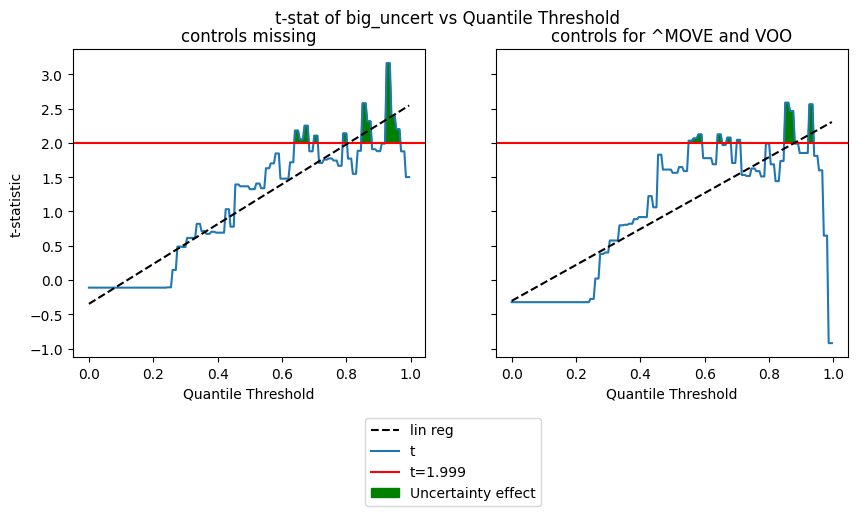

In [43]:
results_1 = []
results_2 = []

for q in np.arange(0, 1, 0.005):
    df_copy = df.copy()
    
    threshold = df_copy["d_uncert"].abs().quantile(q)
    df_copy["big_uncert"] = (df_copy["d_uncert"].abs() > threshold).astype(int)

    y = df_copy["ret"].shift(-1)
    X_1 = sm.add_constant(df_copy[["big_uncert"]])
    X_2 = sm.add_constant(df_copy[["big_uncert", "voo_ret", "move_ret"]])
    
    model_no_control = sm.OLS(y, X_1, missing="drop").fit(
        cov_type="HAC", cov_kwds={"maxlags":MAX_LAGS}
    )
    
    model_controlled = sm.OLS(y, X_2, missing="drop").fit(
        cov_type="HAC", cov_kwds={"maxlags":MAX_LAGS}
    )
    
    results_1.append((q, model_no_control.tvalues["big_uncert"]))
    results_2.append((q, model_controlled.tvalues["big_uncert"]))

results_1_df = pd.DataFrame(results_1, columns=["quantile", "tstat"])
results_2_df = pd.DataFrame(results_2, columns=["quantile", "tstat"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

ax1.plot(results_1_df["quantile"], results_1_df["tstat"])
ax1.axhline(T, color='r')
ax1.fill_between(
    results_1_df["quantile"],
    T,
    results_1_df["tstat"],
    where=list(results_1_df["tstat"] > T),
    interpolate=True,
    color='g',
)
ax1.set_title("t-stat of big_uncert vs Quantile Threshold")

# Fit regression
m1, b1 = np.polyfit(results_1_df["quantile"], results_1_df["tstat"], 1)
ax1.plot(results_1_df["quantile"], m1*results_1_df["quantile"]+b1, '--k', label='lin reg')


ax2.plot(results_2_df["quantile"], results_2_df["tstat"], label='t')
ax2.axhline(T, color='r', label=f't={T:.3f}')
ax2.fill_between(
    results_2_df["quantile"],
    T,
    results_2_df["tstat"],
    where=list(results_2_df["tstat"] > T),
    interpolate=True,
    color='g',
    label='Uncertainty effect'
)

m2, b2 = np.polyfit(results_2_df["quantile"], results_2_df["tstat"], 1)

ax2.plot(results_2_df["quantile"], m2*results_2_df["quantile"]+b2, '--k')

fig.suptitle("t-stat of big_uncert vs Quantile Threshold")

ax1.set_title("controls missing")
ax2.set_title("controls for ^MOVE and VOO")

ax1.set_xlabel("Quantile Threshold")
ax2.set_xlabel("Quantile Threshold")
ax1.set_ylabel("t-statistic")

fig.legend(bbox_to_anchor=(0.6, -0.025));

## Takeaway

There is magnitude dependence. A moderate, threshold-sensitive but directionally stable effect. The effect is strongest around upper-quintile to upper-decile shocks. 

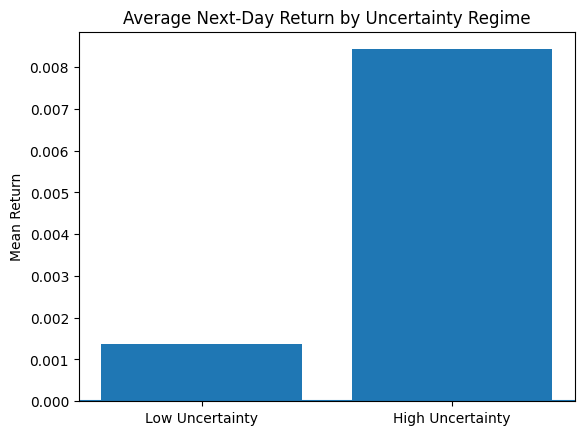

In [44]:
df_plot = df.copy()
df_plot["ret_fwd"] = df_plot["ret"].shift(-1)

group_means = df_plot.groupby("big_uncert")["ret_fwd"].mean()

plt.figure()
plt.bar(["Low Uncertainty", "High Uncertainty"], group_means)
plt.axhline(0)
plt.title("Average Next-Day Return by Uncertainty Regime")
plt.ylabel("Mean Return")
plt.show()

# Strategy
When uncertainty shocks are large, expected next-day returns are higher. So increase exposure in that regime.

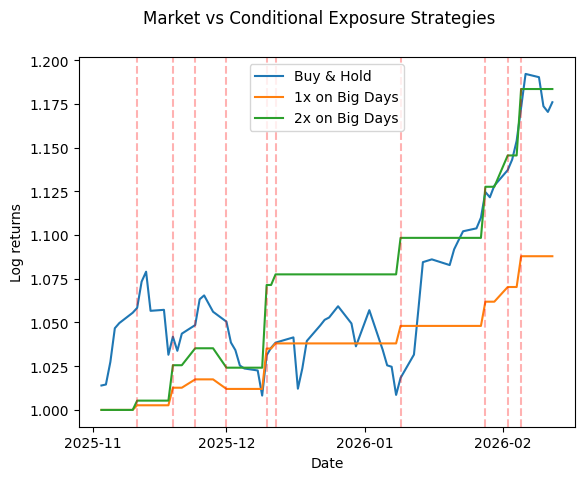

In [45]:
df_plot = df.copy()
df_plot["ret_fwd"] = df_plot["ret"].shift(-1)

# --- Baseline: 1x only on big days ---
df_plot["strategy_ret_1x"] = (
    df_plot["big_uncert"] * df_plot["ret_fwd"]
)

# --- Double-up: 2x only on big days ---
df_plot["strategy_ret_2x"] = (
    2.0 * df_plot["big_uncert"] * df_plot["ret_fwd"]
)

df_plot = df_plot.dropna(subset=["ret_fwd"])

# cumulative returns

df_plot["cum_market"] = np.exp(df_plot["ret_fwd"].cumsum())
df_plot["cum_strategy_1x"] = np.exp(df_plot["strategy_ret_1x"]).cumprod()
df_plot["cum_strategy_2x"] = np.exp(df_plot["strategy_ret_2x"]).cumprod()

fig, ax = plt.subplots()

ax.plot(df_plot.index, df_plot["cum_market"], label="Buy & Hold")
ax.plot(df_plot.index, df_plot["cum_strategy_1x"], label="1x on Big Days")
ax.plot(df_plot.index, df_plot["cum_strategy_2x"], label="2x on Big Days")

for date in df_plot.index[df_plot["big_uncert"] == 1]:
    ax.axvline(x=date, linestyle="--", alpha=0.3, color='r')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.set_xlabel('Date')
ax.set_ylabel('Log returns')

ax.legend()
fig.suptitle("Market vs Conditional Exposure Strategies");

# Sharpe Ratios per Strategy

In [46]:
def sharpe(r):
    return r.mean() / r.std()

def max_drawdown(cum):
    peak = cum.cummax()
    dd = (cum - peak) / peak
    return dd.min()

metrics = pd.DataFrame({
    "Market": [
        df_plot["ret_fwd"].mean(),
        df_plot["ret_fwd"].std(),
        sharpe(df_plot["ret_fwd"]),
        max_drawdown(df_plot["cum_market"])
    ],
    "1x": [
        df_plot["strategy_ret_1x"].mean(),
        df_plot["strategy_ret_1x"].std(),
        sharpe(df_plot["strategy_ret_1x"]),
        max_drawdown(df_plot["cum_strategy_1x"])
    ],
    "2x": [
        df_plot["strategy_ret_2x"].mean(),
        df_plot["strategy_ret_2x"].std(),
        sharpe(df_plot["strategy_ret_2x"]),
        max_drawdown(df_plot["cum_strategy_2x"])
    ],
}, index=["Mean Return", "Volatility", "Sharpe", "Max Drawdown"])

metrics

,Market,1x,2x
Mean Return,0.002419,0.001257,0.002515
Volatility,0.011491,0.004195,0.008391
Sharpe,0.210531,0.299697,0.299697
Max Drawdown,-0.065640,-0.005377,-0.010724


# Interpretation

The findings fit neatly into a well-established thesis about how CME Group's business model is structurally wired to benefit from policy uncertainty.

## Monetization
CME earns revenue almost entirely through transaction fees, making their top line a direct function of volume, and volume a direct function of volatility. "Investors have more differential interpretations of firms’ earnings news when they are uncertain about market conditions" ([Choi](https://www.sciencedirect.com/science/article/pii/S1544612318304021)). Therefore, there is greater variability between CME's stock price and their potential revenue from an uncertain macro regime.

## Polymarket
The uncertainty signal identified in the Polymarket data may a real-time proxy for this dynamic. The days flagged as high-entropy (85th quantile) correspond to moments when the market is genuinely repricing the Fed's reaction function.

The statistically significant positive next-day return following these uncertainty spikes (coef = 0.007288, p = 0.009665) is consistent with the market recognizing, with a slight lag, that volatility regimes are sticky.

## Implications
The conditional strategies match or slightly exceed the market's Sharpe ratio while reducing max drawdown by roughly 92%. This is consistent with the core thesis: uncertainty shocks are identifiable regime signals that carry information about near-term CME earnings power.

## Limitations

1. With only 3 months of daily data, there is a real risk of overfitting to noise.
2. Comparing Sharpe ratios between a fully-invested strategy and a sparse one isn't apples-to-apples.
3. The definition of “big_uncert” relies on quantile thresholds. Thresholding can introduce data-mining risk and inflate t-statistics in small samples.
4. Single-contract dependence. The signal is derived from one specific Fed contract (March 2026) and may not be generalizable.

Critically, causality remains unproven.

## Next Steps
This study is more of a preliminary screen than a publishable result. The most important next step would be expanding the dataset and controlling for VIX or earnings periods.